# Transfer learning / fine-tuning 

En este notebook, vamos a tratar la técnica conocida como *transfer learning* (aprendizaje por transferencia), para lo cual veremos el ejemplo del ajuste de un clasificador de imágenes a partir de un número relativamente pequeño de muestras de entrenamiento. 

En términos generales, **el *transfer learning* se refiere al proceso de aprovechar el conocimiento aprendido en un modelo para el entrenamiento de otro modelo.**

Más específicamente, el proceso implica tomar una red neuronal existente que previamente fue entrenada para un buen rendimiento en un conjunto de datos más grande y usarla como base para un nuevo modelo que aprovecha la precisión de la red anterior para una nueva tarea. 

Este método se ha vuelto popular en los últimos años para mejorar el rendimiento de una red neuronal entrenada en un pequeño conjunto de datos. La intuición es que el nuevo conjunto de datos puede ser demasiado pequeño para entrenarlo con un buen rendimiento por sí mismo, pero sabemos que la mayoría de las redes neuronales entrenadas para aprender características a partir de imágenes a menudo aprenden características similares en todos los casos, especialmente en las primeras capas donde son más genéricas (detectores de borde, manchas, etc.).

El *transfer learning* se ha simplificado en gran medida gracias al código abierto de modelos de vanguardia. Para los modelos de alto rendimiento en tareas de clasificación de imágenes (como los del *ImageNet Large Scale Visual Recognition Challenge*, https://image-net.org/challenges/LSVRC/), ahora es una práctica común no solo publicar la arquitectura, sino también liberar los pesos entrenados del modelo. Esto permite a los aficionados utilizar estos clasificadores de imágenes superiores para mejorar el rendimiento de sus propios modelos específicos de tareas.

## Extracción de funciones vs fine-tuning

En un extremo, el *transfer learning* normalmente implica tomar la red previamente entrenada y congelar los pesos, para después usar una de sus capas ocultas (generalmente la última) como extractor de características, utilizando esas características como entrada a una red neuronal más pequeña.

En el otro extremo, comenzamos con la red previamente entrenada, pero permitimos que se modifiquen algunos de los pesos (generalmente la última capa o las últimas capas). Otro nombre para este procedimiento se llama *"fine-tuning"* porque estamos ajustando ligeramente los pesos de la red previamente entrenada a la nueva tarea. Por lo general, entrenamos una red de este tipo con una tasa de aprendizaje más baja, ya que esperamos que las características ya sean relativamente buenas y no sea necesario cambiarlas demasiado.

A veces, hacemos algo intermedio: congelar solo las capas iniciales / genéricas, pero ajustar las capas posteriores. La mejor estrategia depende del tamaño del conjunto de datos, la cantidad de clases y cuánto se parece al conjunto de datos en el que se entrenó el modelo anterior (y, por lo tanto, si puede beneficiarse de los mismos extractores de características aprendidas). Se puede encontrar una discusión más detallada sobre cómo crear estrategias en los siguientes enlaces:

- https://cs231n.github.io/transfer-learning/
- https://ruder.io/transfer-learning/

## Procedimiento

En esta guía, se realizarán las siguientes tareas:
- La carga de un clasificador de última generación enfocado a identificar imágenes pertenecientes a 1000 clases distintas, el *VGG16*, que ganó el desafío ImageNet en 2014.
- Se usará el clasificador anterior como un extractor de características para entrenar un clasificador personalizado más pequeño en nuestras propias imágenes. Con muy pocos cambios en el código, también se podría intentar realizar un fine-tuning.

El proceso se ejecutará en los siguientes pasos:
- Primero cargaremos VGG16 y eliminaremos su capa final, la capa de clasificación de 1000 clases con función de activación softmax, específica de ImageNet.
- Reemplazaremos la capa final por una nueva capa de clasificación para las clases con las que pretendemos entrenar. 
- Luego, congelaremos todos los pesos de la red, excepto los nuevos pesos que se conectan a la nueva capa de clasificación.
- Entrenaremos la nueva capa de clasificación sobre nuestro nuevo conjunto de datos.
- Compararemos este método con el entrenamiento de una pequeña red neuronal desde cero en el nuevo conjunto de datos y, como veremos, mejorará drásticamente nuestra precisión.
- Como dataset de test, usaremos un conjunto de datos que consta de alrededor de 6000 imágenes que pertenecen a 97 clases y entrenaremos un clasificador de imágenes con cerca del 80% de precisión. Vale la pena señalar que esta estrategia se adapta bien a conjuntos de imágenes donde puede haber incluso menos de 200 imágenes. El rendimiento será menor a partir de una pequeña cantidad de muestras (dependiendo de las clases) como de costumbre, pero seguirá siendo impresionante considerando las limitaciones habituales.

### Setup

In [1]:
import numpy as np

In [92]:
import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Loads an image into PIL format.
from tensorflow.keras.preprocessing import image

#Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Para codificaciones one-hot
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Para cargar el modelo VGG16
from tensorflow.keras.applications import VGG16

### Carga del dataset
El primer paso será cargar nuestros datos, correspondientes al conjunto de datos **CalTech-101**, que contiene alrededor de 9000 imágenes etiquetadas que pertenecen a 101 categorías de objetos. 

Sin embargo, excluiremos 5 de las categorías que tienen más imágenes. Esto es para mantener la distribución de clases bastante equilibrada (alrededor de 50-100) y restringida a un número menor de imágenes, alrededor de 6000.

En Linux, para obtener este conjunto de datos se pueden ejecutar los siguientes comandos:

`wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz`

`tar -xvzf 101_ObjectCategories.tar.gz`

En cualquier caso, la siguiente librería permite realizar el mismo proceso de descarga y funciona en todos los SO:

In [6]:
import urllib.request
url = "http://www.vision.caltech.edu/Image_Datasets/Caltech101"
filename = "101_ObjectCategories.tar.gz"
urllib.request.urlretrieve(url, filename)

('101_ObjectCategories.tar.gz', <http.client.HTTPMessage at 0x23b929c56d8>)

Para descomprimir el archivo recién descargado (que ocupará aproximadamente 132 MB), se puede extraer el .tar, al que después habrá que aplicar el siguiente proceso:

In [18]:
import tarfile 
  
file = tarfile.open("101_ObjectCategories.tar/101_ObjectCategories.tar")  
file.extractall('./') 
file.close() 

El resultado debe ser un nuevo directorio de nombre `101_ObjectCategories` que contendrá todas las subcarpetas asociadas a las categorías de las imágenes.

Si se quiere utilizar otro conjunto de datos, este debe organizarse de la misma manera que el dataset *101_ObjectCategories*, con todas las imágenes organizadas en subcarpetas, una para cada clase. 

En este caso, la siguiente celda permite cargar un conjunto de datos personalizado simplemente reemplazando la raíz con la nueva carpeta en la que se encuentre dicho dataset. 

Una vez se haya descargado el dataset 101_ObjectCategories en nuestro ordenador, la siguiente celda debería cargar todos los datos.

In [106]:
# Categorías a excluir
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']

In [107]:
# Establecemos el root sobre el que vamos a trabajar y lo exploramos
root = '101_ObjectCategories'

for root, dirs, files in os.walk(root):
    if len(dirs) > 0:
        categories = [os.path.join(root, x) for x in dirs if x not in exclude]
categories

['101_ObjectCategories\\accordion',
 '101_ObjectCategories\\anchor',
 '101_ObjectCategories\\ant',
 '101_ObjectCategories\\barrel',
 '101_ObjectCategories\\bass',
 '101_ObjectCategories\\beaver',
 '101_ObjectCategories\\binocular',
 '101_ObjectCategories\\bonsai',
 '101_ObjectCategories\\brain',
 '101_ObjectCategories\\brontosaurus',
 '101_ObjectCategories\\buddha',
 '101_ObjectCategories\\butterfly',
 '101_ObjectCategories\\camera',
 '101_ObjectCategories\\cannon',
 '101_ObjectCategories\\car_side',
 '101_ObjectCategories\\ceiling_fan',
 '101_ObjectCategories\\cellphone',
 '101_ObjectCategories\\chair',
 '101_ObjectCategories\\chandelier',
 '101_ObjectCategories\\cougar_body',
 '101_ObjectCategories\\cougar_face',
 '101_ObjectCategories\\crab',
 '101_ObjectCategories\\crayfish',
 '101_ObjectCategories\\crocodile',
 '101_ObjectCategories\\crocodile_head',
 '101_ObjectCategories\\cup',
 '101_ObjectCategories\\dalmatian',
 '101_ObjectCategories\\dollar_bill',
 '101_ObjectCategories\\dolp

Esta función es útil para preprocesar los datos, cargando cada imagen y devolviéndola junto a un vector de entrada:

In [115]:
def get_image(path):
    
    # Se carga la imagen y se hace un resize, ya que es el tamaño que requiere VGG16 (224x224 RGB)
    img = image.load_img(path, target_size=(224, 224))
    
    # Se transforma a un array
    x = image.img_to_array(img)
    
    # np.expand_dims expande la forma de una matriz
    # Inserta un nuevo eje que aparecerá en la posición
    # del parámetro axis en la forma de matriz expandida.
    
    # "axis" indica la posición en los ejes expandidos 
    # donde se coloca el nuevo eje (o ejes).
    
    # Tamaño inicial de la imagen: (224, 224, 3)
    # Tamaño expandido de la imagen: (1, 224, 224, 3)    
    x = np.expand_dims(x, axis=0)
    
    #Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
    # Devuelve un numpy.array o un tf.Tensor preprocesado con tipo float32.
    x = preprocess_input(x)
    
    return img, x

Ahora, cargaremos todas las imágenes del directorio root:

In [116]:
# Inicializamos una lista para almacenar diccionarios imagen-categoría
data = []

# Para cada índice, categoría:
for c, category in enumerate(categories):
    
    # Inicializamos lista para almacenar las imágenes de la categoría
    images = []
    
    # Para cada root, dir intermedio (vacío), filename en la categoría
    for dp, _, filenames in os.walk(category):
        
        # Para cada nombre de imagen 
        for f in filenames:
            
            # print(os.path.splitext(f)) # Devuelve ('image_0001', '.jpg')
            # Si la extensión del archivo está bien:
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']:
                images.append(os.path.join(dp, f))
                
    for img_path in images:
    
        # Utilizamos ahora la función de carga definida más arriba
        img, x = get_image(img_path)

        # Creamos un diccionario para generar cada X y su target
        data.append({'x':np.array(x[0]), 'y':c})
                
data

[{'x': array([[[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
  
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
  
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
  
         ...,
  
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -11

In [117]:
# Contemos el número de clases
num_classes = len(categories)
num_classes

97

### Particiones de train, validación y test

Vamos a hacer que el orden de los datos sea aleatorio:

In [118]:
random.shuffle(data)

Crearemos ahora las particiones de training / validation / test split (70%, 15%, 15%):

In [119]:
# Particiones de train, validation, test
train_split, val_split = 0.7, 0.15 # Test split: 0.15

In [120]:
# Los datos de entrenamiento se tomarán desde el principio hasta idx_val
idx_val = int(train_split * len(data))
idx_val

4346

In [121]:
# Los datos de test serán los restantes
idx_test = int((train_split + val_split) * len(data))
idx_test

5277

In [122]:
# Los datos de entrenamiento se toman desde el principio hasta idx_val
train = data[:idx_val]

In [123]:
# Los datos de validación se toman desde el idx_val hasta idx_test
val = data[idx_val:idx_test]

# Los datos de test son los restantes
test = data[idx_test:]

Separamos ahora los datos de las etiquetas:

In [124]:
X_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
X_train

array([[[[  36.060997 ,   -9.778999 ,  -61.68     ],
         [  33.060997 ,  -12.778999 ,  -64.68     ],
         [  40.060997 ,   -5.7789993,  -57.68     ],
         ...,
         [ -48.939003 ,  -47.779    ,  -56.68     ],
         [ -49.939003 ,  -48.779    ,  -57.68     ],
         [ -52.939003 ,  -51.779    ,  -62.68     ]],

        [[  36.060997 ,   -8.778999 ,  -58.68     ],
         [  23.060997 ,  -21.779    ,  -71.68     ],
         [  23.060997 ,  -21.779    ,  -71.68     ],
         ...,
         [ -68.939    ,  -67.779    ,  -76.68     ],
         [ -67.939    ,  -67.779    ,  -76.68     ],
         [ -69.939    ,  -68.779    ,  -79.68     ]],

        [[  30.060997 ,   -9.778999 ,  -53.68     ],
         [  17.060997 ,  -22.779    ,  -66.68     ],
         [  17.060997 ,  -22.779    ,  -66.68     ],
         ...,
         [ -67.939    ,  -67.779    ,  -76.68     ],
         [ -65.939    ,  -67.779    ,  -76.68     ],
         [ -65.939    ,  -67.779    ,  -77.68     ]],

In [125]:
print(y_train)

[54, 7, 53, 53, 53, 82, 68, 79, 31, 12, 52, 49, 69, 55, 45, 40, 14, 87, 30, 73, 42, 90, 28, 90, 49, 52, 14, 94, 30, 45, 96, 86, 36, 68, 80, 91, 60, 64, 26, 14, 11, 84, 14, 87, 30, 49, 96, 83, 69, 69, 32, 69, 72, 15, 62, 9, 14, 48, 53, 25, 3, 7, 70, 21, 33, 49, 60, 44, 28, 6, 49, 71, 74, 41, 83, 5, 92, 86, 28, 92, 18, 22, 73, 40, 73, 31, 19, 69, 52, 82, 42, 87, 36, 60, 15, 90, 48, 41, 0, 54, 3, 81, 5, 35, 32, 68, 52, 62, 72, 55, 30, 20, 71, 24, 44, 33, 50, 7, 16, 66, 37, 14, 48, 31, 42, 65, 70, 42, 88, 41, 53, 84, 3, 95, 56, 51, 19, 10, 82, 53, 38, 35, 89, 14, 34, 29, 73, 44, 20, 61, 89, 19, 82, 85, 48, 83, 45, 53, 25, 4, 42, 89, 77, 43, 86, 94, 14, 53, 45, 37, 75, 28, 28, 53, 58, 75, 96, 45, 61, 18, 26, 41, 82, 82, 53, 44, 89, 26, 41, 14, 63, 96, 61, 75, 77, 11, 42, 3, 24, 50, 32, 86, 42, 64, 43, 30, 75, 94, 30, 91, 53, 40, 95, 52, 38, 21, 29, 19, 42, 14, 75, 10, 45, 53, 65, 13, 23, 86, 0, 14, 50, 48, 68, 90, 27, 16, 18, 90, 96, 18, 83, 56, 17, 21, 53, 70, 59, 28, 45, 84, 33, 58, 94, 8

In [126]:
X_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
print(y_val)

[71, 77, 75, 65, 35, 92, 4, 32, 73, 77, 49, 65, 35, 30, 94, 29, 18, 18, 90, 36, 46, 16, 34, 20, 16, 51, 32, 41, 53, 90, 5, 53, 53, 41, 96, 53, 49, 20, 87, 49, 85, 70, 16, 63, 69, 59, 32, 15, 87, 71, 8, 61, 45, 58, 26, 54, 3, 8, 82, 11, 86, 84, 29, 52, 52, 39, 29, 84, 90, 44, 13, 83, 53, 76, 84, 2, 33, 18, 6, 80, 45, 90, 76, 79, 29, 16, 86, 86, 84, 28, 61, 91, 78, 94, 78, 0, 90, 11, 53, 67, 53, 21, 41, 45, 92, 59, 11, 28, 9, 75, 57, 88, 7, 30, 51, 63, 62, 90, 42, 82, 37, 4, 65, 57, 57, 26, 50, 15, 68, 80, 24, 78, 28, 15, 95, 25, 36, 14, 12, 55, 46, 40, 12, 32, 55, 37, 92, 11, 51, 56, 92, 14, 90, 83, 29, 41, 29, 19, 70, 77, 8, 51, 26, 50, 88, 66, 39, 80, 8, 56, 36, 11, 50, 18, 33, 42, 71, 58, 73, 17, 94, 35, 15, 0, 8, 2, 34, 42, 92, 53, 20, 30, 33, 67, 88, 85, 32, 48, 61, 9, 27, 42, 6, 57, 16, 39, 82, 94, 42, 9, 17, 14, 49, 69, 4, 49, 22, 22, 37, 72, 74, 1, 80, 48, 40, 8, 83, 16, 7, 88, 26, 46, 83, 8, 7, 13, 88, 56, 82, 49, 3, 49, 37, 70, 7, 40, 20, 77, 8, 80, 7, 39, 48, 47, 38, 28, 39, 

In [127]:
X_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[64, 70, 59, 95, 22, 17, 88, 59, 59, 75, 28, 3, 70, 13, 47, 65, 23, 9, 87, 87, 17, 76, 8, 71, 27, 9, 51, 36, 72, 87, 93, 75, 72, 89, 88, 53, 17, 52, 89, 49, 54, 79, 40, 40, 81, 41, 93, 34, 85, 62, 5, 29, 23, 66, 62, 34, 25, 74, 41, 23, 21, 13, 82, 90, 40, 96, 73, 78, 22, 18, 3, 62, 68, 5, 33, 5, 35, 13, 13, 90, 76, 92, 74, 81, 86, 21, 18, 68, 12, 45, 71, 54, 34, 39, 53, 71, 15, 14, 23, 7, 58, 39, 66, 42, 77, 14, 87, 1, 53, 56, 29, 96, 10, 90, 36, 30, 35, 95, 94, 69, 90, 90, 16, 59, 61, 53, 70, 59, 67, 59, 3, 61, 70, 94, 45, 90, 18, 53, 3, 38, 90, 34, 28, 92, 88, 85, 27, 4, 45, 8, 89, 35, 84, 29, 1, 27, 68, 61, 5, 64, 50, 45, 88, 29, 86, 16, 42, 43, 77, 68, 41, 28, 14, 84, 2, 36, 7, 30, 11, 70, 90, 43, 88, 90, 90, 70, 46, 96, 90, 11, 3, 30, 67, 88, 69, 49, 48, 34, 96, 33, 92, 59, 1, 29, 62, 82, 43, 90, 14, 14, 83, 36, 49, 64, 15, 14, 53, 10, 95, 59, 50, 18, 9, 62, 27, 90, 7, 94, 19, 43, 90, 84, 31, 90, 50, 66, 13, 75, 53, 0, 28, 58, 80, 76, 14, 20, 20, 28, 89, 4, 16, 91, 58, 65, 46, 66,

### Preprocesamiento previo al modelado

Preprocesaremos los datos para asegurarnos de que sean float32 y estén normalizados entre 0 y 1.

In [128]:
# Normalización
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [129]:
# Conversión de etiquetas en vectores one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [130]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Vamos a echar un vistazo a un resumen de lo que hemos hecho hasta ahora:

In [131]:
print(f"Se han cargado {len(data)} imágenes de {num_classes} categorías")
print(f"Train {len(X_train)} / Validation {len(X_val)} / Test {len(X_test)}")
print(f"Dimensiones de las variables del subconjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y_train.shape}")

Se han cargado 6209 imágenes de 97 categorías
Train 4346 / Validation 931 / Test 932
Dimensiones de las variables del subconjunto de entrenamiento: (4346, 224, 224, 3)
Dimensiones de las etiquetas de entrenamiento: (4346, 97)


Si todo ha ido correctamente, se deberían haber cargado un montón de imágenes, ahora divididas en tres conjuntos: train, val y test. 

La forma de los datos de entrenamiento debe ser (n, 224, 224, 3), donde **n** es el tamaño del conjunto de entrenamiento.

Las etiquetas deben ser de tamaño (n, c), donde **c** es el número de clases (97 en el caso de *101_ObjectCategories*).

Observemos cómo hemos dividido todos los datos en tres subconjuntos:
- Un subconjunto de entrenamiento (train)
- Un subconjunto de validación (val)
- Un subconjunto de prueba (test)

La razón de esto es el poder evaluar adecuadamente la precisión de nuestro clasificador. 

Durante el entrenamiento, el optimizador utiliza el conjunto de validación para evaluar su rendimiento interno, con el fin de determinar el gradiente sin sobreajustar al conjunto de entrenamiento. 

El conjunto de prueba siempre se mantiene fuera del algoritmo de entrenamiento y solo se usa al final para evaluar la precisión final de nuestro modelo.

Veamos rápidamente algunas imágenes de muestra de nuestro conjunto de datos.

In [132]:
images

['101_ObjectCategories\\yin_yang\\image_0001.jpg',
 '101_ObjectCategories\\yin_yang\\image_0002.jpg',
 '101_ObjectCategories\\yin_yang\\image_0003.jpg',
 '101_ObjectCategories\\yin_yang\\image_0004.jpg',
 '101_ObjectCategories\\yin_yang\\image_0005.jpg',
 '101_ObjectCategories\\yin_yang\\image_0006.jpg',
 '101_ObjectCategories\\yin_yang\\image_0007.jpg',
 '101_ObjectCategories\\yin_yang\\image_0008.jpg',
 '101_ObjectCategories\\yin_yang\\image_0009.jpg',
 '101_ObjectCategories\\yin_yang\\image_0010.jpg',
 '101_ObjectCategories\\yin_yang\\image_0011.jpg',
 '101_ObjectCategories\\yin_yang\\image_0012.jpg',
 '101_ObjectCategories\\yin_yang\\image_0013.jpg',
 '101_ObjectCategories\\yin_yang\\image_0014.jpg',
 '101_ObjectCategories\\yin_yang\\image_0015.jpg',
 '101_ObjectCategories\\yin_yang\\image_0016.jpg',
 '101_ObjectCategories\\yin_yang\\image_0017.jpg',
 '101_ObjectCategories\\yin_yang\\image_0018.jpg',
 '101_ObjectCategories\\yin_yang\\image_0019.jpg',
 '101_ObjectCategories\\yin_yan

In [133]:
# Tomamos una muestra aleatoria de imágenes, para lo cual seleccionamos su índice
idx = [int(len(images) * random.random()) for i in range(8)]
idx

[55, 42, 3, 1, 5, 52, 13, 59]

In [134]:
# Las cargamos con keras en formato PIL
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
imgs

[<PIL.Image.Image image mode=RGB size=224x224 at 0x23B988D14E0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1DE48>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1D390>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1D470>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1D240>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1D438>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1DBA8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x23B99E1D898>]

In [135]:
# Convertimos la lista anterior en una lista de arrays de numpy
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
concat_image

array([[[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[102, 255, 102],
        [102, 255, 102],
        [102, 255, 102],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

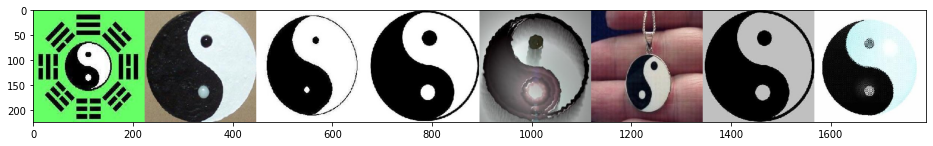

In [136]:
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Entrenamiento de una primera red desde cero

Antes de realizar el *transfer learning*, primero crearemos una red neuronal desde cero para realizar la clasificación en nuestro conjunto de datos. Esto nos dará una línea de base (*baseline*) para comparar con nuestra red de *transfer learning* más adelante.

**La red que construiremos contendrá 4 capas convolucionales y de max-pooling alternas, seguidas de un dropout después de cada par conv / max-pooling.**

Después de la última capa de agrupación, adjuntaremos una capa completamente conectada con 256 neuronas, otra capa de dropout y, finalmente, una capa de clasificación softmax para nuestras clases.

Nuestra función de pérdida será, como de costumbre, pérdida de entropía cruzada categórica (*categorical cross-entropy*), y nuestro algoritmo de aprendizaje será AdaDelta (https://arxiv.org/abs/1212.5701). 

Se pueden cambiar varias cosas acerca de esta red para obtener un mejor rendimiento, como por ejemplo usar una más capas, más neuronas o un optimizador diferente, pero para los propósitos de este cuaderno, el objetivo es simplemente obtener una comprensión de un baseline aproximado con fines de comparación, por lo que no es necesario dedicar mucho tiempo a tratar de optimizar esta red.

Al compilar la red, ejecutaremos *model.summary()* para obtener una instantánea de las capas.

In [137]:
model = Sequential()
print(f"Dimensiones de entrada: {X_train.shape[1:]}")

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Dimensiones de entrada: (224, 224, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_3 (Dropo

Hemos creado una red de tamaño mediano con ~ 1.2 millones de pesos y sesgos (los parámetros). 

Ahora podemos seguir adelante y entrenar nuestro modelo durante 100 *epochs* con un tamaño de lote de 128. También registraremos el historial para poder trazar la pérdida a lo largo del tiempo más adelante.

### Entrenamiento con 10 epochs

In [138]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # Optimizador adadelta
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
34/34 [==============================] - 104s 3s/step - loss: 4.5262 - accuracy: 0.0389 - val_loss: 4.4433 - val_accuracy: 0.0644
Epoch 2/10
34/34 [==============================] - 97s 3s/step - loss: 4.3201 - accuracy: 0.0787 - val_loss: 4.1425 - val_accuracy: 0.1547
Epoch 3/10
34/34 [==============================] - 93s 3s/step - loss: 4.0355 - accuracy: 0.1348 - val_loss: 3.8719 - val_accuracy: 0.2041
Epoch 4/10
34/34 [==============================] - 101s 3s/step - loss: 3.7485 - accuracy: 0.1806 - val_loss: 3.5432 - val_accuracy: 0.2352
Epoch 5/10
34/34 [==============================] - 98s 3s/step - loss: 3.4176 - accuracy: 0.2405 - val_loss: 3.2275 - val_accuracy: 0.3029
Epoch 6/10
34/34 [==============================] - 104s 3s/step - loss: 3.0768 - accuracy: 0.2936 - val_loss: 3.0266 - val_accuracy: 0.3373
Epoch 7/10
34/34 [==============================] - 99s 3s/step - loss: 2.8123 - accuracy: 0.3424 - val_loss: 2.8091 - val_accuracy: 0.3813
Epoch 8/10
34/34 

Tracemos la pérdida de validación y la precisión de la validación a lo largo del tiempo:

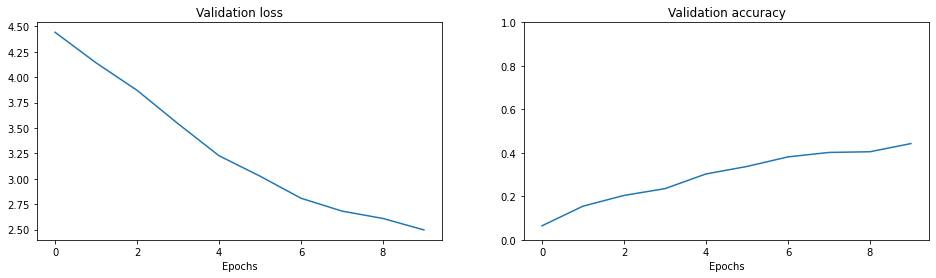

In [139]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()

### Entrenamiento con 20 epochs

In [150]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
34/34 [==============================] - 92s 3s/step - loss: 1.7494 - accuracy: 0.5568 - val_loss: 2.4950 - val_accuracy: 0.4318
Epoch 2/20
34/34 [==============================] - 91s 3s/step - loss: 1.5038 - accuracy: 0.6047 - val_loss: 2.4873 - val_accuracy: 0.4468
Epoch 3/20
34/34 [==============================] - 90s 3s/step - loss: 1.3652 - accuracy: 0.6305 - val_loss: 2.4506 - val_accuracy: 0.4619
Epoch 4/20
34/34 [==============================] - 91s 3s/step - loss: 1.2140 - accuracy: 0.6650 - val_loss: 2.5129 - val_accuracy: 0.4672
Epoch 5/20
34/34 [==============================] - 91s 3s/step - loss: 1.1160 - accuracy: 0.6912 - val_loss: 2.5361 - val_accuracy: 0.4683
Epoch 6/20
34/34 [==============================] - 90s 3s/step - loss: 1.0174 - accuracy: 0.7057 - val_loss: 2.5768 - val_accuracy: 0.4576
Epoch 7/20
34/34 [==============================] - 91s 3s/step - loss: 0.9702 - accuracy: 0.7278 - val_loss: 2.6566 - val_accuracy: 0.4533
Epoch 8/20
34/34 [==

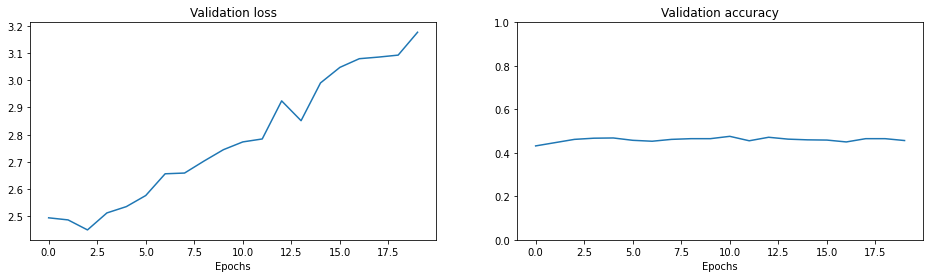

In [151]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()

Hay que tener en cuenta que la pérdida de validación comienza a aumentar después de aproximadamente 13 epochs, aunque la precisión de la validación permanece aproximadamente entre el 40% y el 50%.

Esto sugiere que nuestro modelo comienza a sobreajustarse en ese momento, y el mejor rendimiento se habría logrado si nos hubiéramos detenido antes. 

También podemos llevar a cabo una evaluación final ejecutando nuestro modelo en el conjunto de test. Al hacerlo, obtenemos los siguientes resultados:

In [152]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.1553494930267334
Test accuracy: 0.4742489159107208


Finalmente, vemos que hemos logrado una precisión de alrededor del 47%. Eso no es tan malo para 6000 imágenes, considerando que si tuviéramos que usar una estrategia *naive* de hacer predicciones aleatorias, solo habríamos obtenido alrededor del 1% de precisión.

## Transfer learning con una red existente

Ahora podemos pasar a la estrategia principal para entrenar un clasificador de imágenes en nuestro pequeño conjunto de datos: comenzando con una red más grande y ya entrenada.

Para ello, cargaremos el modelo VGG16 desde keras, que fue entrenado en el dataset *ImageNet*. 

Si es la primera vez que cargamos VGG16, deberemos esperar un poco a que se descarguen los pesos de la web. Una vez cargada la red, podemos volver a inspeccionar las capas con el método *summary()*.

In [141]:
vgg = VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Como podemos ver, VGG16 es mucho más grande que la red que construimos anteriormente. 

Contiene 13 capas convolucionales y dos capas completamente conectadas al final, y tiene más de 138 millones de parámetros, alrededor de 100 veces más parámetros que la red que creamos anteriormente. 

Al igual que nuestra primera red, la mayoría de los parámetros se almacenan en las conexiones que conducen a la primera capa completamente conectada.

Para usar esta red para nuestra tarea, "eliminamos" la capa de clasificación final, la capa softmax de 1000 neuronas al final, que corresponde al dataset ImageNet (está especializada en hacer clasificaciones para estas imágenes), y en su lugar la reemplazamos con una nueva capa softmax para nuestro conjunto de datos, que contiene 97 neuronas en el caso del conjunto de datos 101_ObjectCategories.

En términos de implementación, es más fácil simplemente crear una copia de VGG desde su capa de entrada hasta la penúltima capa, y luego trabajar con eso, en lugar de modificar el objeto VGG directamente. Así que técnicamente nunca "eliminamos" nada, simplemente lo eludimos / ignoramos. 

Esto se puede hacer de la siguiente manera, usando la clase *Model* de keras para inicializar un nuevo modelo cuya capa de entrada es la misma que VGG pero cuya capa de salida es nuestra nueva capa softmax, llamada new_classification_layer. 

*Nota: aunque parece que estamos duplicando esta gran red, internamente Keras en realidad solo está copiando todas las capas por referencia y, por lo tanto, no tenemos que preocuparnos por sobrecargar la memoria.*

In [142]:
# Hacemos referencia a la capa de entrada de VGG
inp = vgg.input

# Creamos una nueva capa softmax con tantas neuronas como num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectamos nuestra nueva capa a la estructura copiada de VGG 
# (desde la segunda hasta la última capa de VGG), 
# y hacemos una referencia a ella
out = new_classification_layer(vgg.layers[-2].output)

# Creamos una nueva red entre inp y out
model_new = Model(inp, out)

Vamos a reentrenar esta red, almacenada en la variable *model_new*, en el nuevo conjunto de datos y etiquetas. 

Para ello, primero debemos congelar los pesos y los sesgos en todas las capas de la red, excepto la nueva al final, con la expectativa de que las características que se aprendieron en VGG aún sean bastante relevantes para la nueva tarea de clasificación de imágenes. No es óptimo, pero lo más probable es que sea mejor de lo que podemos entrenar en nuestro conjunto de datos limitado.

Al configurar la bandera *trainable* en cada capa como False (excepto nuestra nueva capa de clasificación), nos aseguramos de que todos los pesos y sesgos en esas capas permanezcan fijos, y simplemente entrenamos los pesos en una capa al final. 

En algunos casos, es deseable no congelar todas las capas de preclasificación. Si el conjunto de datos tiene suficientes muestras y no se parece mucho a ImageNet, podría ser interesante ajustar algunas de las capas de VGG junto con el nuevo clasificador, o posiblemente incluso todas. Para hacer esto, se puede cambiar el código para hacer más capas entrenables.

En el caso de *CalTech-101*, solo haremos extracción de características, por temor a que un ajuste demasiado fino con este conjunto de datos pueda sobreajustarse.Sin embargo, puede que estemos equivocados, por lo que un buen ejercicio sería probar ambos y comparar los resultados.

Siguiendo adelante, congelamos ahora las capas y compilamos el nuevo modelo con exactamente el mismo optimizador y función de pérdida que en nuestra primera red, en aras de una comparación justa. Luego ejecutamos el resumen nuevamente para ver la arquitectura de la red.

In [143]:
# Hacemos todas las capas "no entrenables" congelando sus pesos (excepto la última)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Nos aseguramos de que la última capa sea entrenable (no esté congelada)
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Si observamos el resumen, vemos que la red es idéntica al modelo VGG que instanciamos anteriormente, a excepción de la última capa, anteriormente un softmax de 1000 neuronas, que ahora ha sido reemplazada por un nuevo softmax de 97 neuronas. 

Además, todavía tenemos aproximadamente 134 millones de pesos, pero ahora la gran mayoría de ellos son "parámetros no entrenables" porque congelamos las capas en las que están contenidos. Ahora solo tenemos 397000 parámetros entrenables, que en realidad es solo una cuarta parte de los número de parámetros necesarios para entrenar el primer modelo.

Como antes, seguimos adelante y entrenamos el nuevo modelo, usando los mismos hiperparámetros (tamaño de lote y número de epochs) que antes, junto con el mismo algoritmo de optimización. También hacemos un seguimiento de su historia a medida que avanzamos.

In [144]:
history2 = model_new.fit(X_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(X_val, y_val))

Epoch 1/10
34/34 [==============================] - 431s 12s/step - loss: 4.0981 - accuracy: 0.1703 - val_loss: 3.1473 - val_accuracy: 0.3029
Epoch 2/10
34/34 [==============================] - 442s 13s/step - loss: 2.5598 - accuracy: 0.4434 - val_loss: 2.3650 - val_accuracy: 0.4715
Epoch 3/10
34/34 [==============================] - 446s 13s/step - loss: 1.9614 - accuracy: 0.5688 - val_loss: 1.9247 - val_accuracy: 0.5532
Epoch 4/10
34/34 [==============================] - 434s 13s/step - loss: 1.6362 - accuracy: 0.6279 - val_loss: 1.6418 - val_accuracy: 0.6219
Epoch 5/10
34/34 [==============================] - 308s 9s/step - loss: 1.4037 - accuracy: 0.6786 - val_loss: 1.6485 - val_accuracy: 0.6165
Epoch 6/10
34/34 [==============================] - 319s 9s/step - loss: 1.2660 - accuracy: 0.7029 - val_loss: 1.4464 - val_accuracy: 0.6584
Epoch 7/10
34/34 [==============================] - 321s 9s/step - loss: 1.1402 - accuracy: 0.7347 - val_loss: 1.3913 - val_accuracy: 0.6692
Epoch 8/1

Nuestra precisión de validación ronda el 80% hacia el final, lo que representa una mejora de más del 30% en la red original entrenada desde cero (es decir, hacemos una predicción incorrecta en el 20% de las muestras, en lugar del 50%).

Vale la pena señalar también que esta red en realidad se entrena un poco más rápido que la red original, ¡a pesar de tener más de 100 veces más parámetros! Esto se debe a que congelar los pesos anula la necesidad de propagar hacia atrás a través de todas esas capas, lo que nos ahorra tiempo de ejecución.

Tracemos la pérdida de validación y la precisión nuevamente, esta vez comparando el modelo original entrenado desde cero (en azul) y el nuevo modelo de transferencia aprendida en verde:

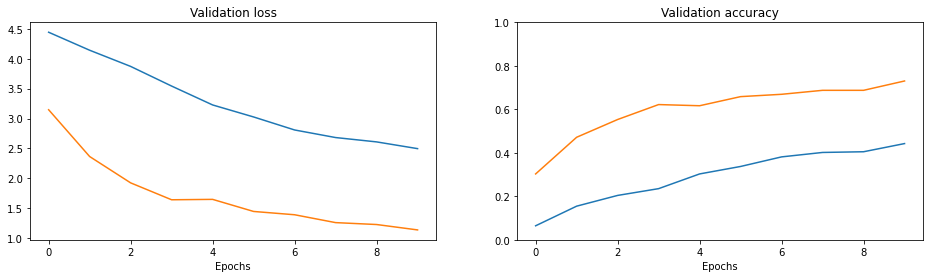

In [145]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()

Tengamos en cuenta que mientras que el modelo original comenzó a sobreajustarse alrededor de la epoch 16, el nuevo modelo continuó disminuyendo lentamente su pérdida con el tiempo y probablemente habría mejorado ligeramente su precisión con más iteraciones. 

El nuevo modelo alcanzó aproximadamente el 80% de precisión (en el conjunto de validación) y continuó mejorando lentamente a lo largo de 100 epochs.

Es posible que pudiéramos haber mejorado el modelo original con una mejor regularización o más dropouts, pero seguramente no hubiéramos compensado la mejora >30% en la precisión.

Nuevamente, hacemos una validación final en el conjunto de prueba.

In [146]:
loss, accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.2029352188110352
Test accuracy: 0.7070815563201904


Para predecir una nueva imagen, simplemente debemos ejecutar el siguiente código para obtener las probabilidades de cada clase:

In [147]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])

In [148]:
probabilities.max()

0.9993949

In [149]:
probabilities.argmax()

17

## Mejorando los resultados
Un 78,2% de precisión en 97 clases, distribuida aproximadamente de manera uniforme, es un logro bastante bueno. 

No es tan impresionante como el VGG16 original, que logró un 73% de precisión en 1000 clases. Sin embargo, es mucho mejor de lo que pudimos lograr con nuestra red original y hay margen de mejora.

Algunas técnicas que posiblemente podrían haber mejorado nuestro desempeño son las siguientes:

- Uso de *data augmentation*: se refiere al uso de varias modificaciones de los datos de entrenamiento originales, en forma de distorsiones, rotaciones, cambios de iluminación, etc. El objetivo es aumentar el tamaño del conjunto de entrenamiento y crear más tolerancia para tales distorsiones.
- Usar un optimizador diferente, agregar más regularización / dropout y probar otros hiperparámetros.
- Entrenando durante más tiempo (por supuesto).

En el blog de Keras se puede encontrar un ejemplo más avanzado de transfer learning en Keras, que además incluye *data augmentation* para un pequeño conjunto de datos de 2 clases: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

***Referencia: https://github.com/ml4a/ml4a/blob/master/examples/fundamentals/transfer_learning.ipynb***